In [1]:
# !pip install tensorflow_datasets

In [2]:
# 필요한 패키지를 import 합니다.

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
# tensorflow-datasets의 cifar-10 데이터셋을 빌드합니다.
# 데이터 셋을 구성하고 있는 특징과 이미지 특징에 대한 정보를 출력합니다.
cifar10_bldr = tfds.builder('cifar10')

print(cifar10_bldr.info.features)
print('\n', 39 * "=", '\n')
print(cifar10_bldr.info.features['image'])

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


Image(shape=(32, 32, 3), dtype=tf.uint8)




In [4]:
# 데이터셋 다운로드 및 사용준비를 합니다.
cifar10_bldr.download_and_prepare()

In [5]:
# train 데이터셋을 로드하여 각 이미지와 라벨을 매핑합니다.
ds_train = cifar10_bldr.as_dataset()['train']

ds_train = ds_train.map(lambda item:
    (item['image'], tf.cast(item['label'], tf.int32))
)

ds_train = ds_train.batch(18)
images, labels = next(iter(ds_train))

print(images.shape, labels)

(18, 32, 32, 3) tf.Tensor([7 8 4 4 6 5 2 9 6 6 9 9 3 0 8 7 9 0], shape=(18,), dtype=int32)


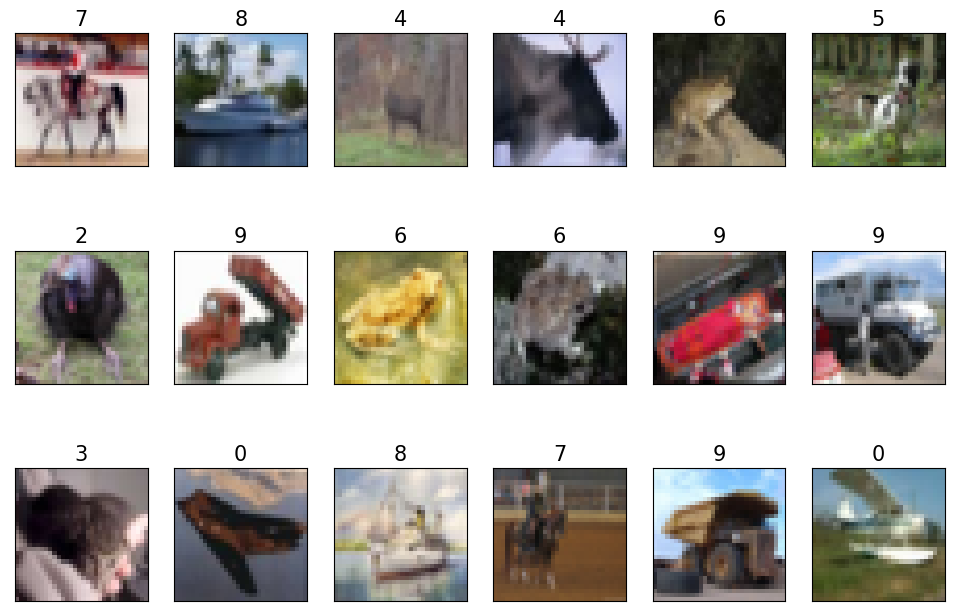

In [6]:
# 학습할 18개의 이미지와 레이블 값을 출력하여 확인합니다.

fig = plt.figure(figsize=(12, 8))
for i, (image, label) in enumerate(zip(images, labels)):
    ax = fig.add_subplot(3, 6, i + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(image)
    ax.set_title('{}'.format(label), size=15)
    
plt.show()

In [7]:
cifar10 = cifar10_bldr.as_dataset(shuffle_files=False)

# 학습 데이터와 테스트 데이터로만 이루어져 있기 때문에,
# 학습 데이터중에서 앞에서 45,000개를 학습 데이터로
# 학습 데이터중에서 45,000개 이후부터 50,000까지 검증 데이터셋으로 할당합니다.
cifar10_train = cifar10['train']
cifar10_test = cifar10['test']

cifar10_valid = cifar10_train.take(5000)
cifar10_train = cifar10_train.skip(5000)

print('훈련 데이터셋: {}'.format(len(cifar10_train)))
print('검증 데이터셋: {}'.format(len(cifar10_valid)))
print('테스트 데이터셋: {}'.format(len(cifar10_test)))

훈련 데이터셋: 45000
검증 데이터셋: 5000
테스트 데이터셋: 10000


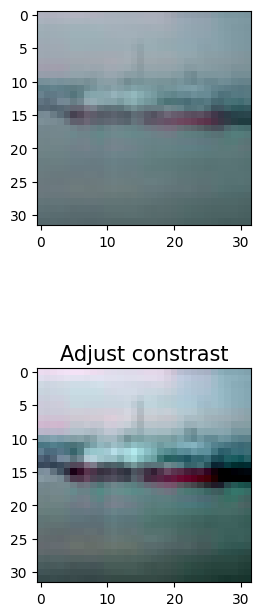

In [8]:
# 대비를 조정하면 이미지가 선명해지는 것을 확인할 수 있습니다.
examples = []
for example in cifar10_train.take(5):
    examples.append(example['image'])

fig = plt.figure(figsize=(16, 8.5))

ax = fig.add_subplot(2, 5, 3)
ax.imshow(examples[2])
ax = fig.add_subplot(2, 5, 8)
ax.set_title('Adjust constrast', size=15)
img_adj_contrast = tf.image.adjust_contrast(
    examples[2], contrast_factor=2)
ax.imshow(img_adj_contrast)

# plt.savefig('images/15_14.png', dpi=300)
plt.show()

In [9]:
# 랜덤으로 이미지를 크롭(데이터 변환)하여 네트워크의 입력으로 사용 

def preprocess(example, size=(32, 32), mode='train'):
    image = example['image']
    label = example['label']
    
    if mode == 'train':
        image_cropped = tf.image.random_crop(
            image, size = (24, 24, 3))
        image_resized = tf.image.resize(
            image_cropped, size=size)
        image_flip = tf.image.random_flip_left_right(
            image_resized)
        return (image_flip/255.0, tf.cast(label, tf.int32))

    else:
        image_cropped = tf.image.crop_to_bounding_box(
            image, offset_height=0, offset_width=0,
            target_height=32, target_width=32)
        image_resized = tf.image.resize(
            image_cropped, size=size)
        return (image_resized/255.0, tf.cast(label, tf.int32))

In [10]:
# 학습에 필요한 변수를 할당합니다.
# 훈련 데이터셋과 검증 데이터셋에 데이터를 변환(전처리)하여 할당합니다.

BATCH_SIZE = 32
BUFFER_SIZE = 1000
IMAGE_SIZE = (32, 32)
num_classes = 10
steps_per_epoch = np.ceil(8000/BATCH_SIZE)

ds_train = cifar10_train.map(
    lambda x: preprocess(x, size=IMAGE_SIZE, mode='train'))
ds_train = ds_train.shuffle(buffer_size = BUFFER_SIZE).repeat()
ds_train = ds_train.batch(BATCH_SIZE)

ds_valid = cifar10_valid.map(
    lambda x: preprocess(x, size=IMAGE_SIZE, mode='eval'))
ds_valid = ds_valid.batch(BATCH_SIZE)

250.0


In [11]:
# 모델 1
# 7강 강의자료의 모델을 일부 변형하여 모델을 생성하였습니다.
# 출력층은 10개의 클래스로 이루어져 있습니다.
# optimizer는 Adam
# 정수 label classification을 위한 SparseCategoricalCrossentropy
# 으로 모델을 구현하였습니다.

model = tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(64, (3, 3), 
        padding='same', 
        activation='relu',
    ),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(rate=0.5),

    tf.keras.layers.Conv2D(
        64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(rate=0.5),

    tf.keras.layers.Conv2D(
        128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(units=1024, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.build(input_shape=(None, 32, 32, 3))
model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])
history = model.fit(ds_train, validation_data=ds_valid,
epochs=20, steps_per_epoch=steps_per_epoch)

Epoch 1/20
250/250 [==============================] - 25s 96ms/step - loss: 2.1707 - accuracy: 0.1819 - val_loss: 2.0621 - val_accuracy: 0.2886
Epoch 2/20
250/250 [==============================] - 24s 96ms/step - loss: 1.9037 - accuracy: 0.2901 - val_loss: 1.8569 - val_accuracy: 0.3428
Epoch 3/20
250/250 [==============================] - 26s 104ms/step - loss: 1.8064 - accuracy: 0.3265 - val_loss: 1.8021 - val_accuracy: 0.3636
Epoch 4/20
250/250 [==============================] - 26s 106ms/step - loss: 1.7412 - accuracy: 0.3575 - val_loss: 1.7132 - val_accuracy: 0.3950
Epoch 5/20
250/250 [==============================] - 26s 104ms/step - loss: 1.6899 - accuracy: 0.3690 - val_loss: 1.6571 - val_accuracy: 0.3996
Epoch 6/20
250/250 [==============================] - 25s 99ms/step - loss: 1.6481 - accuracy: 0.3893 - val_loss: 1.6406 - val_accuracy: 0.4174
Epoch 7/20
250/250 [==============================] - 25s 101ms/step - loss: 1.6351 - accuracy: 0.4027 - val_loss: 1.6441 - val_accur

In [12]:
# 정확도 47% 손실 1.442 수준으로 판별능력이 저조한 모델입니다.

print('accuracy: {:.0f}%'.format(history.history['accuracy'][-1] * 100))
print('loss: {:.3f}'.format(history.history['loss'][-1]))
model.summary()

accuracy: 47%
loss: 1.442
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                          

In [13]:
# 모델 2
# Convolution layer를 한단계 확장 하였습니다.
# 이하 손실함수와 optimizer는 동일합니다.

model = tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(64, (3, 3), 
                           padding='same', 
                           activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Conv2D(64, (3, 3), 
                           padding='same', 
                           activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), 
                           padding='same', 
                           activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(256, (3, 3), 
                           padding='same', 
                           activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),

    tf.keras.layers.Dense(512, activation='relu'),

    tf.keras.layers.Dense(num_classes, activation='softmax'),
])
model.build(input_shape=(None, 32, 32, 3))
model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])
history = model.fit(ds_train, validation_data=ds_valid,
epochs=20, steps_per_epoch=steps_per_epoch)

Epoch 1/20
250/250 [==============================] - 61s 239ms/step - loss: 2.1133 - accuracy: 0.2080 - val_loss: 2.1109 - val_accuracy: 0.2452
Epoch 2/20
250/250 [==============================] - 60s 242ms/step - loss: 1.8615 - accuracy: 0.2994 - val_loss: 2.0106 - val_accuracy: 0.2752
Epoch 3/20
250/250 [==============================] - 63s 252ms/step - loss: 1.7772 - accuracy: 0.3391 - val_loss: 1.9791 - val_accuracy: 0.3080
Epoch 4/20
250/250 [==============================] - 59s 236ms/step - loss: 1.6804 - accuracy: 0.3724 - val_loss: 1.8290 - val_accuracy: 0.3554
Epoch 5/20
250/250 [==============================] - 59s 236ms/step - loss: 1.6360 - accuracy: 0.3924 - val_loss: 1.9239 - val_accuracy: 0.3006
Epoch 6/20
250/250 [==============================] - 60s 241ms/step - loss: 1.5969 - accuracy: 0.4061 - val_loss: 1.7690 - val_accuracy: 0.3762
Epoch 7/20
250/250 [==============================] - 62s 247ms/step - loss: 1.5614 - accuracy: 0.4320 - val_loss: 1.7102 - val_ac

In [14]:
# 정확도 54% 손실 1.281 수준으로
# 레이어를 확장하여 예측률이 향상되었습니다.

print('accuracy: {:.0f}%'.format(history.history['accuracy'][-1] * 100))
print('loss: {:.3f}'.format(history.history['loss'][-1]))
model.summary()

accuracy: 54%
loss: 1.281
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 dropout_4 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 dropout_5 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 128)       73856     
                            

In [16]:
# 이미지 사이즈가 작기때문에 이미지를 크롭하는 것 보다
# 이미지를 선명하게 변환하는 것이 예측률이 향상될 것이라고 가정하고
# 전처리 함수를 정의하였습니다. 

def preprocess1(example, size=(32, 32), mode='train'):
    image = example['image']
    label = example['label']
    
    if mode == 'train':
        img_adj_contrast = tf.image.adjust_contrast(
          image, contrast_factor=2)
        return (img_adj_contrast/255, tf.cast(label, tf.int32))

    else:
        image_cropped = tf.image.crop_to_bounding_box(
            image, offset_height=0, offset_width=0,
            target_height=32, target_width=32)
        image_resized = tf.image.resize(
            image_cropped, size=size)
        return (image_resized/255.0, tf.cast(label, tf.int32))

In [17]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
IMAGE_SIZE = (32, 32)
num_classes = 10
steps_per_epoch = np.ceil(8000/BATCH_SIZE)
print(steps_per_epoch)

ds_train = cifar10_train.map(
    lambda x: preprocess1(x, size=IMAGE_SIZE, mode='train'))
ds_train = ds_train.shuffle(buffer_size = BUFFER_SIZE).repeat()
ds_train = ds_train.batch(BATCH_SIZE)

ds_valid = cifar10_valid.map(
    lambda x: preprocess1(x, size=IMAGE_SIZE, mode='eval'))
ds_valid = ds_valid.batch(BATCH_SIZE)

250.0


In [18]:
# 상기 모델 1과 동일합니다.
# 정확도 62% 손실 1.08 수준으로
# 이미지 크롭 변환 방식보다 
# 이미지의 선명도를 증가시키는 것이 예측률 향상에 더 크게 작용하였습니다.

model = tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(64, (3, 3), 
        padding='same', 
        activation='relu',
    ),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(rate=0.5),

    tf.keras.layers.Conv2D(
        64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(rate=0.5),

    tf.keras.layers.Conv2D(
        128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(units=1024, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.build(input_shape=(None, 32, 32, 3))
model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])
history = model.fit(ds_train, validation_data=ds_valid,
epochs=20, steps_per_epoch=steps_per_epoch)

Epoch 1/20
250/250 [==============================] - 21s 81ms/step - loss: 2.0798 - accuracy: 0.2280 - val_loss: 2.2318 - val_accuracy: 0.1636
Epoch 2/20
250/250 [==============================] - 23s 91ms/step - loss: 1.6985 - accuracy: 0.3740 - val_loss: 2.1110 - val_accuracy: 0.2346
Epoch 3/20
250/250 [==============================] - 25s 101ms/step - loss: 1.5647 - accuracy: 0.4296 - val_loss: 2.2173 - val_accuracy: 0.2038
Epoch 4/20
250/250 [==============================] - 23s 92ms/step - loss: 1.4851 - accuracy: 0.4551 - val_loss: 2.1395 - val_accuracy: 0.2472
Epoch 5/20
250/250 [==============================] - 24s 95ms/step - loss: 1.4329 - accuracy: 0.4733 - val_loss: 2.3524 - val_accuracy: 0.2106
Epoch 6/20
250/250 [==============================] - 24s 96ms/step - loss: 1.3878 - accuracy: 0.4980 - val_loss: 2.0153 - val_accuracy: 0.3032
Epoch 7/20
250/250 [==============================] - 24s 96ms/step - loss: 1.3622 - accuracy: 0.5107 - val_loss: 2.4007 - val_accuracy

In [19]:
model = tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(64, (3, 3), 
                           padding='same', 
                           activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Conv2D(64, (3, 3), 
                           padding='same', 
                           activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), 
                           padding='same', 
                           activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(256, (3, 3), 
                           padding='same', 
                           activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),

    tf.keras.layers.Dense(512, activation='relu'),

    tf.keras.layers.Dense(num_classes, activation='softmax'),
])
model.build(input_shape=(None, 32, 32, 3))
model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])
history = model.fit(ds_train, validation_data=ds_valid,
epochs=20, steps_per_epoch=steps_per_epoch)

Epoch 1/20
250/250 [==============================] - 63s 249ms/step - loss: 1.9938 - accuracy: 0.2652 - val_loss: 2.1891 - val_accuracy: 0.1746
Epoch 2/20
250/250 [==============================] - 64s 258ms/step - loss: 1.5954 - accuracy: 0.4121 - val_loss: 2.2498 - val_accuracy: 0.1464
Epoch 3/20
250/250 [==============================] - 64s 255ms/step - loss: 1.4516 - accuracy: 0.4787 - val_loss: 2.0803 - val_accuracy: 0.2558
Epoch 4/20
250/250 [==============================] - 66s 265ms/step - loss: 1.3582 - accuracy: 0.5075 - val_loss: 2.0125 - val_accuracy: 0.2642
Epoch 5/20
250/250 [==============================] - 66s 264ms/step - loss: 1.3306 - accuracy: 0.5241 - val_loss: 2.0784 - val_accuracy: 0.2416
Epoch 6/20
250/250 [==============================] - 66s 266ms/step - loss: 1.2729 - accuracy: 0.5422 - val_loss: 2.0188 - val_accuracy: 0.2862
Epoch 7/20
250/250 [==============================] - 70s 282ms/step - loss: 1.2101 - accuracy: 0.5665 - val_loss: 2.2473 - val_ac